In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

***Load The Dataset***

In [3]:
# LOAD THE DATASET :
df = pd.read_csv("../Data/raw/subset_data.csv")
# DISPLAY THE FIRST 5 ROWS :
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


***Dataset Overview***

In [7]:
# SHAPE OF THE DATASET :
print(f"Shape of the dataset : {df.shape}")

Shape of the dataset : (50000, 9)


In [9]:
# COLUMNS INFORMATIONS :
print("Column Count,Names and The data type (dtype) of each column :")
df.info()

Column Count,Names and The data type (dtype) of each column :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    50000 non-null  object 
 1   user_id      50000 non-null  object 
 2   business_id  50000 non-null  object 
 3   stars        50000 non-null  float64
 4   useful       50000 non-null  int64  
 5   funny        50000 non-null  int64  
 6   cool         50000 non-null  int64  
 7   text         50000 non-null  object 
 8   date         50000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [11]:
# STATISTICS OF NUMERICAL COLUMNS :
df.describe()

,stars,useful,funny,cool
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,3.848000,0.889540,0.250440,0.345060
std,1.350308,1.864481,0.941455,1.072388
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,91.000000,38.000000,49.000000


***Handling Duplicated Values***

In [14]:
# CHECKING FOR DUPLICATED VALUES :
df_duplicates = df.duplicated()
print(f"number of duplicated rows : {df_duplicates.sum()}")

number of duplicated rows : 0


***Handling Missing Values***

In [17]:
# CHECKING FOR MISSING VALUES :
df.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

***Target Distribution***

In [20]:
# ASSINING EACH STAR VALUE A SENTIMENT :
df.loc[df['stars'] == 3, 'sentiment'] = 'neutral' 
df.loc[df['stars'] < 3, 'sentiment'] = 'negative' 
df.loc[df['stars'] > 3, 'sentiment'] = 'positive'

sentiment
positive    34941
negative     9382
neutral      5677
Name: count, dtype: int64


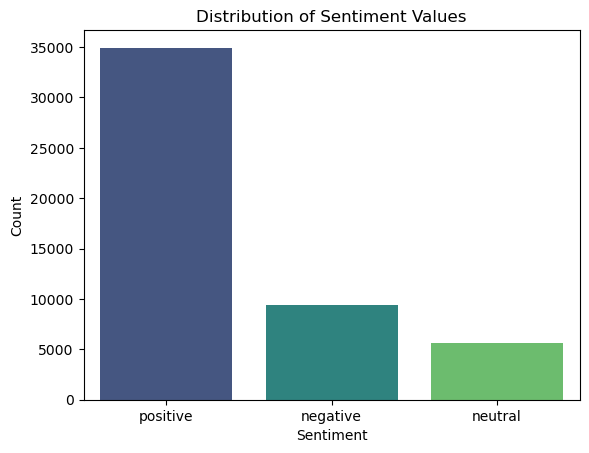

In [22]:
# VISUALIZING THE DISTRIBUTION OF SENTIMENT VALUES :
sentiment = df['sentiment'].value_counts()
print(sentiment)
# Convert to a DataFrame for sns.barplot compatibility
sentiment_counts_df = sentiment.reset_index()
sentiment_counts_df.columns = ['sentiment', 'count']

# Create a bar plot for the distribution of sentiment values
sns.barplot(data=sentiment_counts_df, x='sentiment', y='count',hue='sentiment', palette="viridis",legend=False)

# Adding title and labels
plt.title('Distribution of Sentiment Values')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()

In [24]:
# NEW DATASET :
df_reviews = df[['sentiment','text']]
# DISPLAY THE FIRST 5 ROWS
df_reviews.head()

,sentiment,text
0,neutral,"If you decide to eat here, just be aware it is..."
1,positive,I've taken a lot of spin classes over the year...
2,neutral,Family diner. Had the buffet. Eclectic assortm...
3,positive,"Wow! Yummy, different, delicious. Our favo..."
4,positive,Cute interior and owner (?) gave us tour of up...


# Text Preprocessing 

***Convert Text to Lowercase***

In [28]:
# PREPERING TEXT :
df_reviews.loc[:,'text'] = df_reviews["text"].str.lower()
df_reviews.head()

,sentiment,text
0,neutral,"if you decide to eat here, just be aware it is..."
1,positive,i've taken a lot of spin classes over the year...
2,neutral,family diner. had the buffet. eclectic assortm...
3,positive,"wow! yummy, different, delicious. our favo..."
4,positive,cute interior and owner (?) gave us tour of up...


***Remove Punctuations From Text***

In [31]:
# Removal of Punctuations !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
import string

PUNCT_TO_REMOVE = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_reviews.loc[:,"text"] = df_reviews["text"].apply(lambda text: remove_punctuation(text))

df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***Remove Numbers From Text***

In [33]:
# Removal of Numbers
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace(r'\d+', '', regex=True) 

df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***replacing \n and \r***

In [37]:
# Replace Newline and Carriage Return Characters
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace('\n',' ', regex=True).str.replace('\r','', regex=True)

df_reviews.head()

,sentiment,text
0,neutral,if you decide to eat here just be aware it is ...
1,positive,ive taken a lot of spin classes over the years...
2,neutral,family diner had the buffet eclectic assortmen...
3,positive,wow yummy different delicious our favorite...
4,positive,cute interior and owner gave us tour of upcom...


***Download tokenizer models And WordNet database***

In [40]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

***Remove StopWords From Text***

In [42]:
# Removal of stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_reviews.loc[:, "text"] = df_reviews["text"].apply(lambda text: remove_stopwords(text))

df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take hours beginning en...
1,positive,ive taken lot spin classes years nothing compa...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave us tour upcoming pati...


***Text Lemmatization*** 

In [45]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df_reviews.loc[:,'text'] = df_reviews['text'].apply(lemmatize_text)

df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take hour beginning end...
1,positive,ive taken lot spin class year nothing compare ...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave u tour upcoming patio...


***Remove Extra Space From Text***

In [49]:
# Removing Extra space
df_reviews.loc[:,'text'] = df_reviews['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

df_reviews.head()

,sentiment,text
0,neutral,decide eat aware going take hour beginning end...
1,positive,ive taken lot spin class year nothing compare ...
2,neutral,family diner buffet eclectic assortment large ...
3,positive,wow yummy different delicious favorite lamb cu...
4,positive,cute interior owner gave u tour upcoming patio...


***Text Tokenization***

In [52]:
# Tokenization
df_reviews.loc[:,'tokens'] = df_reviews['text'].apply(word_tokenize)

df_reviews.head()

,sentiment,text,tokens
0,neutral,decide eat aware going take hour beginning end...,"[decide, eat, aware, going, take, hour, beginn..."
1,positive,ive taken lot spin class year nothing compare ...,"[ive, taken, lot, spin, class, year, nothing, ..."
2,neutral,family diner buffet eclectic assortment large ...,"[family, diner, buffet, eclectic, assortment, ..."
3,positive,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l..."
4,positive,cute interior owner gave u tour upcoming patio...,"[cute, interior, owner, gave, u, tour, upcomin..."


***Relationship Between Sentiment and Length of Text***

In [55]:
# CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
df_reviews.loc[:, 'length'] = df_reviews['text'].apply(len)

df_reviews.head()

,sentiment,text,tokens,length
0,neutral,decide eat aware going take hour beginning end...,"[decide, eat, aware, going, take, hour, beginn...",275
1,positive,ive taken lot spin class year nothing compare ...,"[ive, taken, lot, spin, class, year, nothing, ...",540
2,neutral,family diner buffet eclectic assortment large ...,"[family, diner, buffet, eclectic, assortment, ...",260
3,positive,wow yummy different delicious favorite lamb cu...,"[wow, yummy, different, delicious, favorite, l...",150
4,positive,cute interior owner gave u tour upcoming patio...,"[cute, interior, owner, gave, u, tour, upcomin...",380


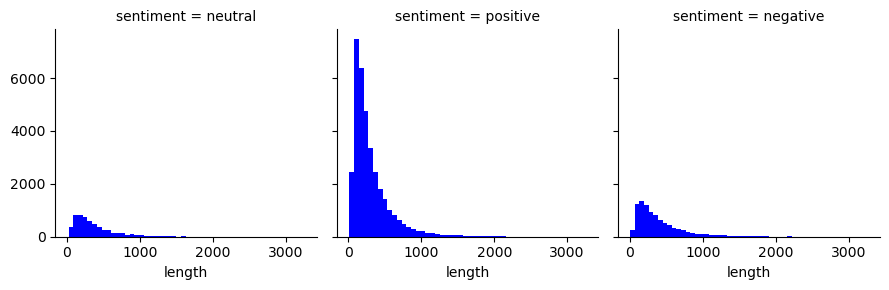

In [57]:
# COMPARING TEXT LENGTH TO SENTIMENT
graph = sns.FacetGrid(data=df_reviews,col='sentiment')
graph.map(plt.hist,'length',bins=50,color='blue')

# Feature Encoding

***Feature Encoding For Text Using The TF-IDF(TfidfVectorizer)***

In [61]:
# Combine token lists back into a single string for each review
df_reviews.loc[:,'processed_text'] = df_reviews['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed text to get the TF-IDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(df_reviews['processed_text'])
print(f"the shape of the TF-IDF matrix :{X_tfidf.shape}")

the shape of the TF-IDF matrix :(50000, 59732)


***Feature Encoding For Sentiment Using OrdinalEncoder***

In [64]:
# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['negative', 'neutral', 'positive']])

# Fit and transform the 'sentiment' column
y = ordinal_encoder.fit_transform(df_reviews[['sentiment']])

y = y.flatten()

# Check the result
print(f"the shape of target :{y.shape}")

the shape of target :(50000,)


In [66]:
# Initialize the RandomOverSampler with a custom ratio (2x for minority class)
# "positive" class remains the same, others doubled
oversampler = RandomOverSampler(sampling_strategy={0: len(y[y == 0])*2, 1: len(y[y == 1])*2,  2: len(y[y == 2])},random_state=42)

# Apply the oversampling to balance the classes
X_resampled, y_resampled = oversampler.fit_resample(X_tfidf, y)
unique, counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution in resampled target: {dict(zip(unique, counts))}")

Class distribution in resampled target: {0.0: 18764, 1.0: 11354, 2.0: 34941}


# Data splitting

In [69]:
# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)